# Simple Modeling & Evaluation
My model is RNN-GRU model. I train the model to get 3 month future growth.

### Import Packages

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Functions

In [2]:
# train test split & scaler
def train_test(all_data, time_steps, for_periods):

    # training & test set
    train = all_data[:'2019'].values
    test = all_data['2020':].values
    train_len = len(train)
    test_len = len(test)
    
    # min max scaler
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    train = sc.fit_transform(train.reshape(-1,1))
    
    # train & test slicing with time steps and periods
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps, train_len-for_periods+1):
        X_train.append(train[i-time_steps:i])
        y_train.append(train[i:i+for_periods])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # reshape to 3-dimensional
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # preparing to create X_test
    inputs = pd.concat((all_data[:'2019'], all_data['2020':]), axis=0).values
    inputs = inputs[len(inputs) - len(test) - time_steps:]
    inputs = sc.transform(inputs.reshape(-1,1))
    
    X_test = []
    for i in range(time_steps, test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, sc
        

In [3]:
# GRU model
def GRU_model(X_train, y_train, X_test, sc, artist):
    # import
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
    # GRU architecture
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=13))
    
    # Compile
    my_GRU_model.compile(optimizer=SGD(learning_rate=0.05, decay=1e-7, momentum=0.9, nesterov=False), 
                         loss='mean_squared_error')
    
    # Early Stop, Model Checkpoint
    es = EarlyStopping(patience=30)
    mc = ModelCheckpoint('../models/checkpoint/{}.h5'.format(artist), save_best_only=True, monitor='val_loss')
    
    # Fitting
    history = my_GRU_model.fit(X_train[:-26], y_train[:-26], epochs=150, batch_size=8, verbose=0, validation_data=(X_train[-26:], y_train[-26:]), callbacks=[es, mc])
    my_GRU_model.load_weights('../models/checkpoint/{}.h5'.format(artist))
                     
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction, history

In [4]:
# actual vs pred plot
def actual_pred_plot(actual, preds):
    actual_pred = pd.DataFrame(columns=['Actual', 'Predict'])
    actual_pred['Actual'] = actual['2020':][0:len(preds)]
    actual_pred['Predict'] = preds
    
    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Actual']), np.array(actual_pred['Predict']))
    
    return m.result().numpy(), actual_pred.plot()
    

### Load Data

In [5]:
# Load artists_dict
with open('../data/final/artists_dict.pickle', 'rb') as artists:
    artists_dict = pickle.load(artists)
    artists.close()

In [6]:
df = artists_dict['BTS'].dropna()

### Preprocessing - Post Malone

##### Train Test Split & Scale

In [7]:
X_train, y_train, X_test, sc = train_test(df, 5, 13)

##### Modeling

In [8]:
my_GRU_model, GRU_prediction, history = GRU_model(X_train, y_train, X_test, sc, 'FSM')

2022-06-01 15:59:17.592977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 15:59:17.593076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-06-01 15:59:17.837151: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-01 15:59:18.991348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:19.164332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:19.197962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:19.257597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:19.321585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:19.768122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

2022-06-01 15:59:31.987825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:32.038693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:59:32.061181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:xlabel='Date'>

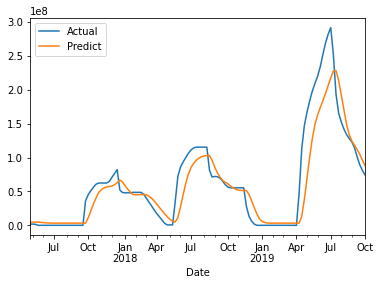

In [9]:
pred = sc.inverse_transform(my_GRU_model.predict(X_train))
actual_pred_2 = pd.DataFrame(columns=['Actual', 'Predict'])
actual_pred_2['Actual'] = df[:'2019'][5:len(pred)+5]
actual_pred_2['Predict'] = pred

actual_pred_2.plot()

RMSE: 9940178000000000.0


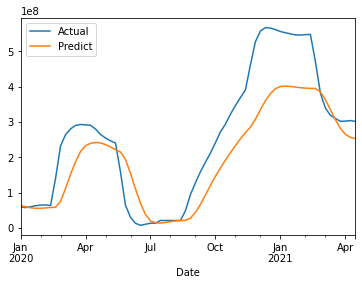

In [10]:
rmse, actual_pred = actual_pred_plot(df, GRU_prediction)
actual_pred.plot()
print('RMSE:', rmse)

In [11]:
my_GRU_model.save('../models/FSM.h5')


<AxesSubplot:>

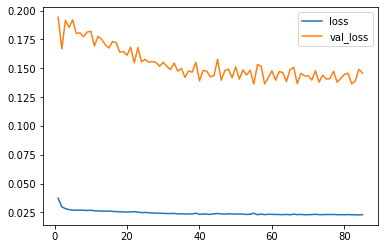

In [12]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
epochs = range(1, len(loss_value)+1)
train_val_df = pd.DataFrame(columns=['loss', 'val_loss'], index=epochs)
train_val_df['loss'] = loss_value
train_val_df['val_loss'] = val_loss_value
train_val_df.plot()